# **Book Genre Classifier: Exploring Various Approaches for Genre Classification**

 In this exploration, I delve into cutting-edge techniques and traditional methods to tackle the fascinating challenge of classifying book genres.

**Section 1: Fine-Tuning Huggingface Transformer LLMs**
> In **Part 1a**,  we review the process of fine-tuning Huggingface Transformer Language Models (LLMs) for genre predictions. Moving on to **Part 1b**, I employ the PEFT/LoRA technique, shedding light on its potential in genre classification.

**Section 2: Genre Classification with scikit-learn and nltk**
> Moving into Section 2, we're using reliable tools like scikit-learn and nltk to understand how to sort things into categories, like different genres. We're checking out how well these tools work and when they're useful. We tried different models, like Support Vector, Naive Bayes, and Random Forest, to see which one works the best. After lots of testing, we picked the one that performed the best. This shows a hands-on way to classify genres effectively.


**Why understanding book genres is interesting and important:**

It's difficult to figure out what genre a book is based on its title and summary, but it's important for several reasons.

* **Recommendation systems:** A good genre classifier can help recommendation systems give readers more personalized book recommendations, which can lead to more reader engagement on digital platforms.
* **Literary success:** Understanding the relationship between genres and how they're portrayed in summaries can give us insights into what makes books commercially successful, or where they could be improved.
* **Book themes and trends:** Studying book genres can help us better understand the themes and trends in the publishing industry, which can be valuable for cultural and societal studies.

Let the journey begin!


## **Part 1a. Fine-Tuning Huggingface Transformer LLMs**

In [ ]:
%%bash

pip install -q transformers
pip install -q datasets
pip install -q peft
pip install -q rouge_score
pip install -q loralib
pip install -q peft
pip install -q evaluate
pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import Trainer, TrainingArguments
import numpy as np
import seaborn as sns
import torch
import re

### Loading and Analyzing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Python/Projects/project_1_books_classification/book_classifier/BooksDataSet.csv .

Mounted at /content/drive


In [ ]:
dataset = load_dataset('csv', data_files='BooksDataSet.csv', split='train')
dataset = dataset.remove_columns(['Unnamed: 0', 'book_id'])
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['book_name', 'genre', 'summary'],
    num_rows: 3000
})

In [ ]:
max_length = max(len(sample['summary']) for sample in dataset)
print(f"The length of the longest text content is: {max_length}")

The length of the longest text content is: 31263


In [ ]:
model_name = 'nreimers/MiniLM-L3-H384-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

(…)L3-H384-uncased/resolve/main/config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

(…)M-L3-H384-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)H384-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)sed/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
dataset.set_format('pandas')
df = dataset[:]

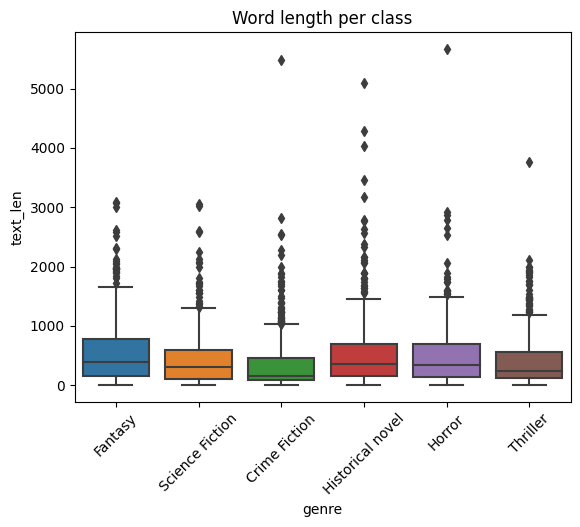

In [ ]:
df['text_len'] = df['summary'].apply(lambda x: len(x.split(" ")))
sns.boxplot(data=df, x='genre', y='text_len')
plt.title("Word length per class")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df[df['text_len'] == df['text_len'].min()]

,book_name,genre,summary,text_len
338,The Caverns of Kalte,Fantasy,==Receptio,2
1574,Guardians of Ga'Hoole Book 4: The Siege,Historical novel,==Receptio,2
2410,The Eyes of Darkness,Horror,==Character,2


In [ ]:
df[df['text_len'] > 4000].sort_values(by='text_len', ascending=False)

,book_name,genre,summary,text_len
2054,El Príncipe de la Niebla,Horror,"Max Carver, son of a watchmaker, has moved wi...",5664
1277,The Scapegoat,Crime Fiction,"'I left the car by the side of the cathedral,...",5475
1634,The King Must Die,Historical novel,"The story is told by Theseus, looking back on...",5089
1700,The Great Indian Novel,Historical novel,The organization of the sections and chapters...,4289
1871,The Wake of the Lorelei Lee,Historical novel,"In the previous book, Rapture of the Deep, Ja...",4026


In [ ]:
dataset.reset_format()

In [ ]:
dataset[338]

{'book_name': 'The Caverns of Kalte',
 'genre': 'Fantasy',
 'summary': ' ==Receptio'}

In [ ]:
## cleaning the text
def cleantext(example):

    text = example['summary']
    # removing the "\" (most of the times '\' is an escape character)
    text = re.sub("'\'","",text)

    # removing special symbols
    text = re.sub("[^a-zA-Z]"," ",text)

    # removing the unnecesary whitespaces
    text = ' '.join(text.split())

    # convert text to lowercase
    text = text.lower()
    example['summary'] = text
    return example


dataset = dataset.map(cleantext)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
dataset[338]

{'book_name': 'The Caverns of Kalte',
 'genre': 'Fantasy',
 'summary': 'receptio'}

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to('cuda')
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

pytorch_model.bin:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L3-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 17392134
all model parameters: 17392134
percentage of trainable model parameters: 100.00%


In [ ]:
print(print_number_of_trainable_model_parameters(model.classifier))

trainable model parameters: 2310
all model parameters: 2310
percentage of trainable model parameters: 100.00%


In [ ]:
mapping = dict(zip(df['genre'].unique(), list(range(6))))
mapping

{'Fantasy': 0,
 'Science Fiction': 1,
 'Crime Fiction': 2,
 'Historical novel': 3,
 'Horror': 4,
 'Thriller': 5}

In [ ]:
df['labels'] = [mapping.get(item) for item in df['genre']]

In [ ]:
dataset = dataset.add_column('labels', df['labels'])

In [ ]:
index = 2000
dataset['genre'][index], dataset['labels'][index]

('Horror', 4)

In [ ]:
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits['train']
test_ds = splits['test']

train_ds, test_ds

(Dataset({
     features: ['book_name', 'genre', 'summary', 'labels'],
     num_rows: 2400
 }),
 Dataset({
     features: ['book_name', 'genre', 'summary', 'labels'],
     num_rows: 600
 }))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_function(example):
    example['input_ids'] = tokenizer(example['summary'], padding=True, truncation=True).input_ids
    example['attention_mask'] = tokenizer(example['summary'], padding=True, truncation=True).attention_mask
    # example['labels'] = torch.tensor(example['labels'])
    return example

train_tokenized = train_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)
train_tokenized, test_tokenized

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

(Dataset({
     features: ['book_name', 'genre', 'summary', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 2400
 }),
 Dataset({
     features: ['book_name', 'genre', 'summary', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 600
 }))

In [ ]:
train_tokenized = train_tokenized.remove_columns(['book_name', 'genre', 'summary'])
test_tokenized = test_tokenized.remove_columns(['book_name', 'genre', 'summary'])
train_tokenized, test_tokenized

(Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 2400
 }),
 Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 600
 }))

In [ ]:
train_tokenized['input_ids'][0]

[101,
 11471,
 2007,
 6996,
 1996,
 8687,
 8391,
 1997,
 6039,
 10253,
 2007,
 2010,
 2522,
 11117,
 16292,
 9965,
 1998,
 6423,
 1996,
 16669,
 2332,
 15969,
 3504,
 2005,
 2019,
 6172,
 2000,
 2507,
 2010,
 2166,
 2070,
 3574,
 2002,
 13239,
 1037,
 2911,
 1998,
 7930,
 2007,
 6423,
 2010,
 6802,
 1998,
 5591,
 2280,
 2293,
 3037,
 2000,
 1996,
 6058,
 2479,
 2000,
 8145,
 2067,
 7773,
 2013,
 1996,
 2555,
 2320,
 2045,
 15969,
 21811,
 2015,
 2408,
 1037,
 8867,
 6925,
 4953,
 2698,
 3585,
 6309,
 1996,
 3945,
 2005,
 2028,
 1997,
 1996,
 6309,
 2006,
 1037,
 3518,
 2479,
 9554,
 10255,
 15969,
 1998,
 6423,
 2067,
 2000,
 3011,
 2007,
 9428,
 2053,
 2126,
 2000,
 2709,
 2000,
 6039,
 10253,
 1996,
 3535,
 2000,
 2709,
 4150,
 15969,
 1998,
 6423,
 1055,
 2047,
 4895,
 18447,
 21945,
 8795,
 2006,
 3011,
 15969,
 1998,
 6423,
 2136,
 2039,
 2007,
 6498,
 1998,
 2010,
 2767,
 19745,
 2040,
 3046,
 2000,
 4681,
 2068,
 1999,
 2037,
 2709,
 2247,
 1996,
 2126,
 2037,
 4990,
 7502,
 206

In [ ]:
length = []
for value in train_tokenized['input_ids']:
    length.append(len)

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

### Training

In [ ]:
rm -rf MiniLM-L3-H384-uncased-fine-tuned-book-genres/

In [ ]:
name = model_name.split("/")[-1]
model_names = f"{name}-fine-tuned-book-genres"
args = TrainingArguments(
    output_dir=model_names,
    evaluation_strategy="steps",
    eval_steps=500,
    auto_find_batch_size=True,
    num_train_epochs=10,
    seed=0,
    load_best_model_at_end=True,
    )

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

In [ ]:
del trainer

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.320700,1.125524,0.625000,0.637810,0.625000,0.620853
1000,0.711600,1.314119,0.595000,0.627780,0.595000,0.592605
1500,0.399400,1.394762,0.641667,0.652630,0.641667,0.635831
2000,0.196000,1.587612,0.671667,0.679835,0.671667,0.667128
2500,0.105100,1.795240,0.663333,0.671375,0.663333,0.658718
3000,0.076800,1.871006,0.668333,0.675197,0.668333,0.663739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted

TrainOutput(global_step=3000, training_loss=0.46825604502360024, metrics={'train_runtime': 309.3756, 'train_samples_per_second': 77.576, 'train_steps_per_second': 9.697, 'total_flos': 403609927680000.0, 'train_loss': 0.46825604502360024, 'epoch': 10.0})

In [ ]:
res = trainer.evaluate()
res

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


{'eval_loss': 1.1255240440368652,
 'eval_accuracy': 0.625,
 'eval_precision': 0.6378104519193544,
 'eval_recall': 0.625,
 'eval_f1': 0.620853316909507,
 'eval_runtime': 2.3575,
 'eval_samples_per_second': 254.51,
 'eval_steps_per_second': 31.814,
 'epoch': 10.0}

## **Part 1b. Leveraging PEFT/LoRA Technique**

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=64, # Rank
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)

In [ ]:
peft_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to('cuda')
lora_model = get_peft_model(peft_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(lora_model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L3-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model parameters: 297216
all model parameters: 17687046
percentage of trainable model parameters: 1.68%


In [ ]:
from transformers import TrainingArguments, Trainer

peft_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{peft_name}-book-genre-lora",
    learning_rate=1e-4,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    eval_steps=500,
    remove_unused_columns=False,
    label_names=["labels"],
    seed=42,
)

In [ ]:
lora_trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

In [ ]:
lora_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.790275,0.151667,0.046165,0.151667,0.058710
2,1.788200,1.741070,0.331667,0.159632,0.331667,0.208515
3,1.788200,1.689164,0.330000,0.176065,0.330000,0.205977
4,1.713200,1.665932,0.366667,0.361371,0.366667,0.249046
5,1.660600,1.648124,0.386667,0.395596,0.386667,0.275935
6,1.660600,1.636864,0.398333,0.374073,0.398333,0.287368
7,1.634400,1.629392,0.438333,0.476923,0.438333,0.365019
8,1.634400,1.618014,0.465000,0.554980,0.465000,0.396049
9,1.615900,1.612758,0.471667,0.519771,0.471667,0.411347
10,1.603000,1.605588,0.480000,0.541842,0.480000,0.425840


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average

TrainOutput(global_step=6000, training_loss=1.6253465474446616, metrics={'train_runtime': 521.1825, 'train_samples_per_second': 92.098, 'train_steps_per_second': 11.512, 'total_flos': 850706399232000.0, 'train_loss': 1.6253465474446616, 'epoch': 20.0})

In [ ]:
lora_res= lora_trainer.evaluate()
lora_res

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


{'eval_loss': 1.5894196033477783,
 'eval_accuracy': 0.515,
 'eval_precision': 0.5324050992104428,
 'eval_recall': 0.515,
 'eval_f1': 0.46907524323508937,
 'eval_runtime': 2.512,
 'eval_samples_per_second': 238.849,
 'eval_steps_per_second': 29.856,
 'epoch': 20.0}

---

## **2. Genre Classification with scikit-learn and nltk**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics

In [ ]:
# Loading Dataset
books = pd.read_csv('BooksDataSet.csv')
books.head()

,Unnamed: 0,book_id,book_name,genre,summary
0,0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...


In [ ]:
# Removing the 'Unnamed : 0' column

books = books.drop('Unnamed: 0', axis=1)
books.head()

,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...


In [ ]:
# Summary of the DataFrame's structure and information about its columns.
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   book_id    3000 non-null   int64 
 1   book_name  3000 non-null   object
 2   genre      3000 non-null   object
 3   summary    3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.9+ KB


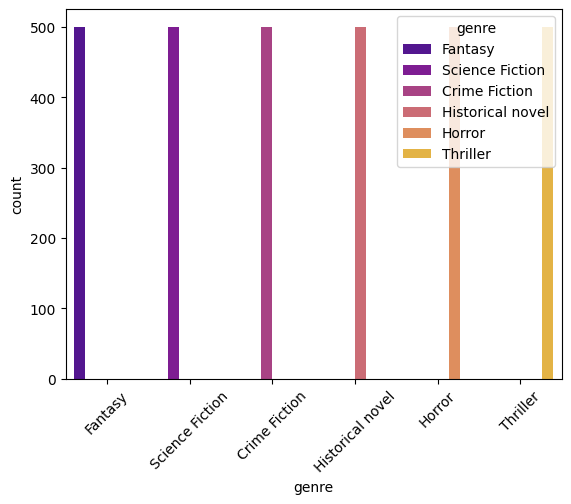

In [ ]:
# Visualizing the distribution of 'genre' in the 'books' DataFrame.

sn.countplot(x=books['genre'], hue=books['genre'], palette='plasma')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Before cleaning the text, let's see how is the summary
books['summary'].iloc[0]

' Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur\'s side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday\'s Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew\'s treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoev

In [ ]:
books['summary'] = books['summary'].str.replace(r'\\', '')

<ipython-input-44-ebc4459bf443>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  books['summary'] = books['summary'].str.replace(r'\\', '')


In [ ]:
books['summary'].iloc[0]

' Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur\'s side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday\'s Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew\'s treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoev

'\\' is an escape character however let's clean it.

In [ ]:
## cleaning the text

def cleantext(text):

    # removing the "\" (most of the times '\' is an escape character)
    text = re.sub("'\'","",text)

    # removing special symbols
    text = re.sub("[^a-zA-Z]"," ",text)

    # removing the unnecesary whitespaces
    text = ' '.join(text.split())

    # convert text to lowercase
    text = text.lower()

    return text


books['summary'] = books['summary'].apply(lambda x:cleantext(x))
books['summary'].iloc[0]

'drowned wednesday is the first trustee among the morrow days who is on arthur s side and wishes the will to be fulfilled she appears as a leviathan whale and suffers from gluttony the book begins when leaf is visiting arthur and they are discussing the invitation that drowned wednesday sent him arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter tuesday s treasure tower suddenly the hospital room becomes flooded with water as the two are transported to the border sea of the house leaf is snatched away by a large ship with green sails known as the flying mantis while arthur remains in his bed when the medallion given him by the immortal called the mariner apparently fails to summon help arthur is without hope eventually a buoy marking the pirate elishar feverfew s treasure floats toward him as soon as arthur opens it his hand is marked with a bloody red colour arthur now has the red hand by which feverfew marks whoever has found his tre

#### Plotting the most Frequent Words

In [ ]:
text = ['drowned wednesday is the first trustee among the morrow days', 'who is on arthur s side and wishes the will to be fulfilled she appears as a leviathan whale and suffers from gluttony the book begins when leaf is visiting arthur and they are discussing the invitation that drowned wednesday sent him arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter tuesday s treasure tower suddenly the hospital room becomes flooded with water as the two are transported to the border sea of the house leaf is snatched away by a large ship with green sails known as the flying mantis while arthur remains in his bed when the medallion given him by the immortal called the mariner apparently fails to summon help arthur is without hope eventually a buoy marking the pirate elishar feverfew s treasure floats toward him as soon as arthur opens it his hand is marked with a bloody red colour arthur now has the red hand by which feverfew marks whoever has found his treasure so that he can identify them later not long after a scavenging ship called the moth rescues arthur on board arthur going by the name of arth is introduced to sunscorch the first mate and to captain catapillow their journey brings them through the line of storms and into the border sea where they are later pursued by feverfew s ghostly ship the shiver the damage inflicted on the moth is serious therefore sunscorch commands an upper house sorcerer dr scamandros to open a transfer portal to elsewhere in the secondary realms scamandros claims that arthur is carrying something that interfered with his magic and tells sunscorch to throw him overboard as a last resort arthur shows them the mariner s medallion which stops scamandros saying that they must get rid of arthur after going through the transfer portal with arthur s help the ship is grounded on a beach when arthur wished to learn what happened to leaf dr scamandros applies his sorcery to make it possible she is revealed to be aboard the ship flying mantis arthur joins catapillow for supper later to reveal his identity at first propaganda issued by dame primus arthur s steward makes them skeptical of this but they eventually become convinced a few days later wednesday s dawn takes arthur to meet wednesday for her luncheon of seventeen removes as they approach wednesday shrinks into her human form to meet arthur during their lunch wednesday tells arthur that after part of the will has been released she will surrender the third key to arthur arthur is then taken by wednesday s dawn to a place called the triangle in search of his friend leaf he learns that leaf has been forced to work on the mantis but is otherwise intact arthur later makes a deal with the raised rats a group of anthropomorphic rats brought to the house by the piper to take him to feverfew s hideout which they believe is inside a miniature world located within drowned wednesday s stomach on the raised rats ship arthur opens a gift from dr scamandros which proves to be a golden transfer watch with this he communicates with and rescues dr scamandros he then uses a scrying mirror dr scamandros gave him to watch leaf a rat watches him during the scry and later saves him from a battle with feverfew later the rats bring arthur onto their submarine where he meets with suzy turquiose blue in contrast to suzy s former cockney attitude she has assumed a more ladylike and proper demeanor on the orders of dame primus only when they are no longer on the border sea but under it does she resume her customary ways of speech and dress they are with navigational difficulty able to enter the stomach of lady wednesday and the worldlet therein there arthur and suzy disguised as rats find escaped slaves professed followers of the carp these exiles take them to the carp who is the third part of the will they are halted in their attempt to escape by feverfew who proposes that each of them will try to kill the other by means of one strike only arthur fails his first try then dodges feverfew and severs his head leaf who is feverfew s prisoner then kicks it into a mud puddle containing nothing which consumes it upon his death the worldlet begins to collapse via the moth arthur and all his friends with the exception of the reluctant catapillow are able to escape lady wednesday recovers from her gluttony then dies as a result of being poisoned by the worldlet which had opened a void to nothing arthur now duke of the border sea appoints sunscorch as his noon and scamandros as his dusk fr mercredi sous les flots th']
nltk.FreqDist(' '.join([char for char in text]).split())

FreqDist({'the': 54, 'to': 34, 'arthur': 28, 'a': 22, 'of': 20, 'is': 16, 'and': 15, 'his': 14, 's': 13, 'with': 12, ...})

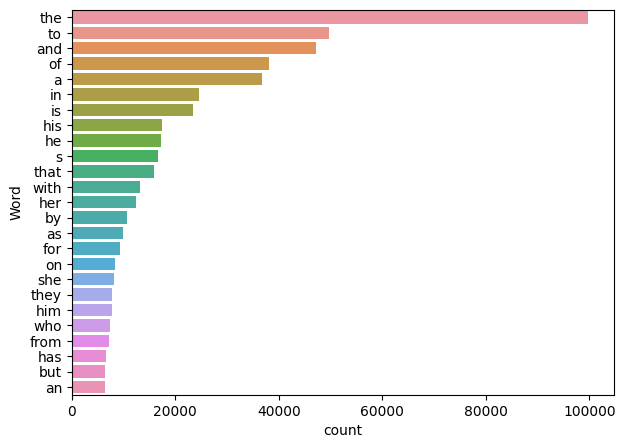

In [ ]:
def showmostfrequentwords(text,no_of_words):

    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)

    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})

    df = wordsdf.nlargest(columns="count",n = no_of_words)

    plt.figure(figsize=(7,5))
    ax = sn.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()

    return wordsdf


# 25 most frequent words

wordsdf = showmostfrequentwords(books['summary'],25)

In [ ]:
wordsdf.sort_values('count',ascending=False).head(10).style.background_gradient(cmap='plasma')

,word,count
3,the,99808
17,to,49665
14,and,47183
46,of,38003
23,a,36749
80,in,24496
2,is,23358
49,his,17464
51,he,17210
12,s,16709


### Removing the stopwords

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# removing the stopwords
def removestopwords(text):

    removedstopword = [word for word in text.split() if word not in stop_words]
    return ' '.join(removedstopword)

books['summary'] = books['summary'].apply(lambda x:removestopwords(x))
books['summary'].iloc[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'book opens jason awakens school bus unable remember anything past sitting next piper mclean leo valdez call name say girlfriend best friend respectively three part class field trip grand canyon arrive classmate dylan turns venti storm spirit attacks trio trip leader coach gleeson hedge ensuing fight jason surprises everyone including one coins turns sword uses battle storm spirits coach hedge reveals satyr fight taken captive fleeing spirit battle flying chariot arrives rescue trio one people annabeth upset discovers missing boyfriend percy jackson expected annabeth seeking percy told vision goddess hera look guy one shoe turns jason shoe destroyed fight jason piper leo told demigods taken back camp half blood meet greek demigod children like leo revealed son hephaestus piper daughter aphrodite jason son zeus though hera tells champion jason later discovers full brother zeus demigod daughter thalia grace hunter artemis shortly arrive three given quest rescue hera captured set soon dis

## Lemmatizing

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


books['summary'] = books['summary'].apply(lambda x: lematizing(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
books['summary'][0]

'drowned wednesday first trustee among morrow day arthur side wish fulfilled appears leviathan whale suffers gluttony book begin leaf visiting arthur discussing invitation drowned wednesday sent arthur admitted hospital damage done leg attempted enter tuesday treasure tower suddenly hospital room becomes flooded water two transported border sea house leaf snatched away large ship green sail known flying mantis arthur remains bed medallion given immortal called mariner apparently fails summon help arthur without hope eventually buoy marking pirate elishar feverfew treasure float toward soon arthur open hand marked bloody red colour arthur red hand feverfew mark whoever found treasure identify later long scavenging ship called moth rescue arthur board arthur going name arth introduced sunscorch first mate captain catapillow journey brings line storm border sea later pursued feverfew ghostly ship shiver damage inflicted moth serious therefore sunscorch command upper house sorcerer dr scam

## Stemming

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentence):

    stemmed_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmed_sentence+=stem
        stemmed_sentence+=" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

books['summary'] = books['summary'].apply(lambda text:stemming(text))
books['summary'].iloc[0]

'drown wednesday first truste among morrow day arthur side wish fulfil appear leviathan whale suffer gluttoni book begin leaf visit arthur discuss invit drown wednesday sent arthur admit hospit damag done leg attempt enter tuesday treasur tower suddenli hospit room becom flood water two transport border sea hous leaf snatch away larg ship green sail known fli manti arthur remain bed medallion given immort call marin appar fail summon help arthur without hope eventu buoy mark pirat elishar feverfew treasur float toward soon arthur open hand mark bloodi red colour arthur red hand feverfew mark whoever found treasur identifi later long scaveng ship call moth rescu arthur board arthur go name arth introduc sunscorch first mate captain catapillow journey bring line storm border sea later pursu feverfew ghostli ship shiver damag inflict moth seriou therefor sunscorch command upper hous sorcer dr scamandro open transfer portal elsewher secondari realm scamandro claim arthur carri someth inter

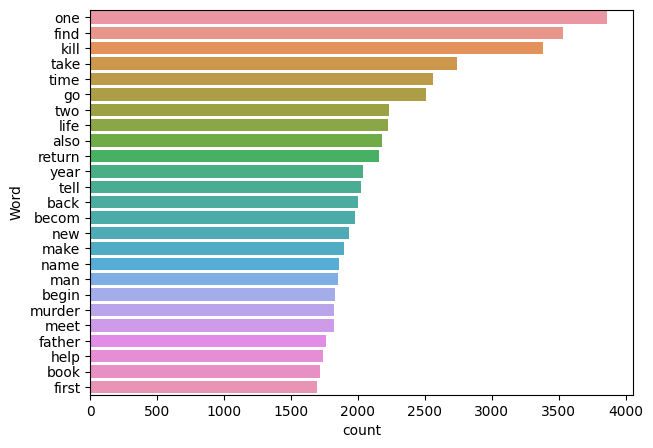

In [ ]:
# Visualising Frequent Words

freq_df = showmostfrequentwords(books['summary'],25)

In [ ]:
freq_df.sort_values('count',ascending=False).head(10).style.background_gradient(cmap = 'plasma')

,word,count
242,one,3858
230,find,3533
240,kill,3380
153,take,2743
1143,time,2563
88,go,2509
38,two,2235
418,life,2224
415,also,2179
407,return,2158


##  Encoding

In [ ]:
books_list = list(books['genre'].unique())
encode = [i for i in range(len(books_list))]
mapper = dict(zip(books_list,encode))
print(mapper)

{'Fantasy': 0, 'Science Fiction': 1, 'Crime Fiction': 2, 'Historical novel': 3, 'Horror': 4, 'Thriller': 5}


In [ ]:
books['genre'] = books['genre'].map(mapper)
books['genre'].unique()

array([0, 1, 2, 3, 4, 5])

## Model Building

In [ ]:
## count vectorizer

count_vec = CountVectorizer(max_df=0.90,
                            min_df=0.0,
                            max_features=1000,
                            stop_words='english')

bagofword_vec = count_vec.fit_transform(books['summary'])
bagofword_vec

<3000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 245415 stored elements in Compressed Sparse Row format>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec,
                                                    books['genre'],
                                                    test_size=0.2)
X_train.shape,X_test.shape

((2400, 1000), (600, 1000))

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()
svc.fit(X_train,y_train)
svccpred = svc.predict(X_test)
print(metrics.accuracy_score(y_test,svccpred))

0.5733333333333334


In [ ]:
mb = MultinomialNB()
mb.fit(X_train,y_train)
mbpred = mb.predict(X_test)
print(metrics.accuracy_score(y_test,mbpred))

0.6416666666666667


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print(metrics.accuracy_score(y_test,rf.predict(X_test)))

0.6116666666666667


## Part 2 Model Building

 + Changing from Countvectorizer to TFDIF vectorizer

In [ ]:
# Loading Dataset
books_new = pd.read_csv('BooksDataSet.csv')
books_new.head()

,Unnamed: 0,book_id,book_name,genre,summary
0,0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...


In [ ]:
#Labeling each 'genre' with a unique number

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(books['genre'])

X_train,X_test,y_train,y_test = train_test_split(books['summary'],
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

X_train.shape,X_test.shape

((2400,), (600,))

In [ ]:
#Performing tf-idf

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
xtest_tfidf = tfidf_vectorizer.transform(X_test.values.astype('U'))

In [ ]:
svc = SVC()
svc.fit(xtrain_tfidf,y_train)
svccpred = svc.predict(xtest_tfidf)
print(metrics.accuracy_score(y_test,svccpred))

0.7216666666666667


In [ ]:
mb = MultinomialNB()
mb.fit(xtrain_tfidf,y_train)
mbpred = mb.predict(xtest_tfidf)
print(metrics.accuracy_score(y_test,mbpred))

0.7133333333333334


In [ ]:
rf = RandomForestClassifier()
rf.fit(xtrain_tfidf,y_train)
rfpred = rf.predict(xtest_tfidf)
print(metrics.accuracy_score(y_test,rfpred))

0.6283333333333333


## Testing the Model

In [ ]:
def test(text,model):

    text = cleantext(text)
    text = removestopwords(text)
    text = lematizing(text)
    text = stemming(text)

    text_vector = tfidf_vectorizer.transform([text])
    predicted = model.predict(text_vector)
    return predicted


ans = books['summary'].apply(lambda text:test(text,mb))

# printing the
# print(list(mapper.keys())[list(mapper.values()).index(ans)])

ans

0       [3]
1       [0]
2       [0]
3       [0]
4       [0]
       ... 
2995    [5]
2996    [5]
2997    [5]
2998    [5]
2999    [2]
Name: summary, Length: 3000, dtype: object

In [ ]:
predicted_genres = []
for i in range(len(ans)):

    index_val = ans[i][0]
    predicted_genres.append(list(mapper.keys())[list(mapper.values()).index(index_val)])


In [ ]:
mapper

{'Fantasy': 0,
 'Science Fiction': 1,
 'Crime Fiction': 2,
 'Historical novel': 3,
 'Horror': 4,
 'Thriller': 5}

In [ ]:
## mapping the training genre as well
newmap = dict([(value,key) for key,value in mapper.items()])
newmap

{0: 'Fantasy',
 1: 'Science Fiction',
 2: 'Crime Fiction',
 3: 'Historical novel',
 4: 'Horror',
 5: 'Thriller'}

In [ ]:
print(newmap)

{0: 'Fantasy', 1: 'Science Fiction', 2: 'Crime Fiction', 3: 'Historical novel', 4: 'Horror', 5: 'Thriller'}


In [ ]:
books['Actual Genre'] = books['genre'].map(newmap)
books['Predicted_genre'] = np.array(predicted_genres)
books.head()

,book_id,book_name,genre,summary,Actual Genre,Predicted_genre
0,3248537,Drowned Wednesday,0,drown wednesday first truste among morrow day ...,Fantasy,Historical novel
1,27796919,The Lost Hero,0,book open jason awaken school bu unabl rememb ...,Fantasy,Fantasy
2,3910776,The Eyes of the Overworld,0,cugel easili persuad merchant fianosth attempt...,Fantasy,Fantasy
3,5969644,Magic's Promise,0,book open herald mage vanyel return countri va...,Fantasy,Fantasy
4,3173445,Taran Wanderer,0,taran gurgi return caer dallben follow event t...,Fantasy,Fantasy


In [ ]:
books = books[['book_name','summary','Actual Genre','Predicted_genre']]
books

,book_name,summary,Actual Genre,Predicted_genre
0,Drowned Wednesday,drown wednesday first truste among morrow day ...,Fantasy,Historical novel
1,The Lost Hero,book open jason awaken school bu unabl rememb ...,Fantasy,Fantasy
2,The Eyes of the Overworld,cugel easili persuad merchant fianosth attempt...,Fantasy,Fantasy
3,Magic's Promise,book open herald mage vanyel return countri va...,Fantasy,Fantasy
4,Taran Wanderer,taran gurgi return caer dallben follow event t...,Fantasy,Fantasy
...,...,...,...,...
2995,White Death,novel numa file kurt austin adventur novel mai...,Thriller,Thriller
2996,Venus with Pistol,gilbert kemp dealer special antiqu gun london ...,Thriller,Thriller
2997,Blackwater,know deep davey alway live shadow older brothe...,Thriller,Thriller
2998,The Rainbow and the Rose,stori concern life johnni pasco retir commerci...,Thriller,Thriller


In [ ]:
dict(Counter(books['Actual Genre'].values))

{'Fantasy': 500,
 'Science Fiction': 500,
 'Crime Fiction': 500,
 'Historical novel': 500,
 'Horror': 500,
 'Thriller': 500}

In [ ]:
dict(Counter(books['Predicted_genre'].values))

{'Historical novel': 527,
 'Fantasy': 418,
 'Science Fiction': 547,
 'Thriller': 486,
 'Horror': 500,
 'Crime Fiction': 522}

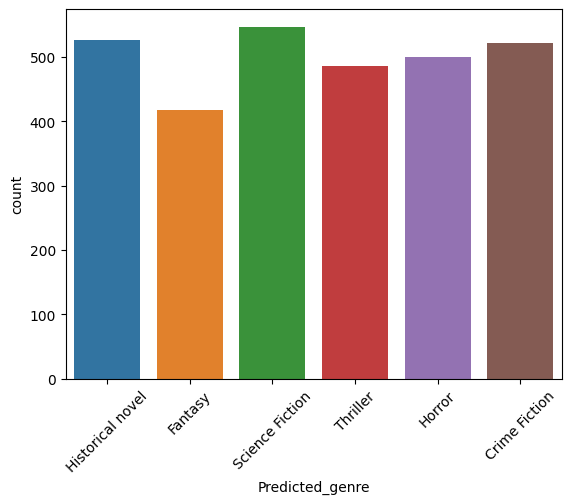

In [ ]:
sn.countplot(x = books['Predicted_genre'])
plt.xticks(rotation=45)
plt.show()

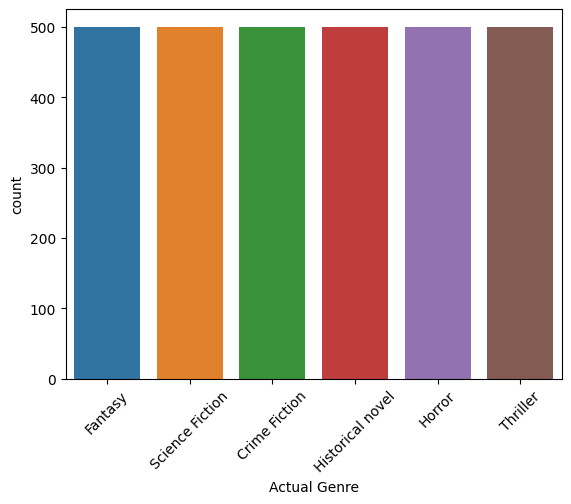

In [ ]:
sn.countplot(x = books['Actual Genre'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
# saving the model
import pickle
with open('bookgenremodel2.pkl','wb') as fp:
    pickle.dump(mb,fp)

In [ ]:
books['summary'].iloc[0]

'drown wednesday first truste among morrow day arthur side wish fulfil appear leviathan whale suffer gluttoni book begin leaf visit arthur discuss invit drown wednesday sent arthur admit hospit damag done leg attempt enter tuesday treasur tower suddenli hospit room becom flood water two transport border sea hous leaf snatch away larg ship green sail known fli manti arthur remain bed medallion given immort call marin appar fail summon help arthur without hope eventu buoy mark pirat elishar feverfew treasur float toward soon arthur open hand mark bloodi red colour arthur red hand feverfew mark whoever found treasur identifi later long scaveng ship call moth rescu arthur board arthur go name arth introduc sunscorch first mate captain catapillow journey bring line storm border sea later pursu feverfew ghostli ship shiver damag inflict moth seriou therefor sunscorch command upper hous sorcer dr scamandro open transfer portal elsewher secondari realm scamandro claim arthur carri someth inter

In [ ]:
tfidf_vectorizer

TfidfVectorizer(max_df=0.8, max_features=10000)

In [ ]:
with open('tfdifvector2.pkl','wb') as fp:
    pickle.dump(tfidf_vectorizer,fp)

In [ ]:
wordnet_down = nltk.download('wordnet',download_dir='./')
wordnet_down

[nltk_data] Downloading package wordnet to ./...


True

In [ ]:
nltk.download('stopwords',download_dir='./')

[nltk_data] Downloading package stopwords to ./...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip freeze > requirements.txt